In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

sns.set(style="whitegrid")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/google-play-store-reviews/reviews.csv


# Visualizamos los datos de las resenas y su rating

Total de registros: 12495
                                             content  score
0                      I cannot open the app anymore      1
1  I have been begging for a refund from this app...      1
2  Very costly for the premium version (approx In...      1
3  Used to keep me organized, but all the 2020 UP...      1
4                                Dan Birthday Oct 28      1


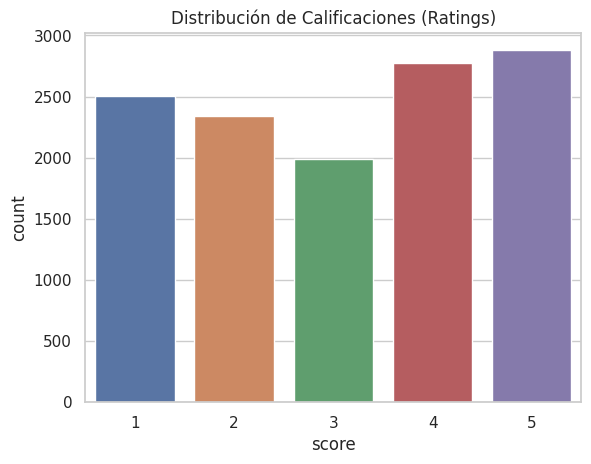

In [2]:
df = pd.read_csv('/kaggle/input/google-play-store-reviews/reviews.csv')
df = df[['content', 'score']].dropna()

print(f"Total de registros: {len(df)}")
print(df.head())

# Visualizar la distribución de los scores
sns.countplot(x='score', data=df)
plt.title('Distribución de Calificaciones (Ratings)')
plt.show()